# Volatility surface calibration
#### Dmitry Bazanov, Roland Grinis, Ivan Novikov, Maksim Sosnin

In [6]:
import numpy as np
import pandas as pd
import numba as nb
from scipy.stats import norm
import matplotlib.pyplot as plt
import plotly.graph_objects as go
plt.style.use("dark_background")
pd.set_option('display.max_columns', 1000)
pd.set_option("display.precision", 2)
%matplotlib inline

## 1. Implied Volatility

#### 1.1 CDF Approximation
Zelen & Severo approximation for the standard normal CDF $\text{N}(x) = \frac{1}{\sqrt{2\pi}}\int^x_{-\infty} \text{d}z \exp(-z^2/2)$ is given by: 
$$
\text{N}(x) = 1 - \text{N}'(x) \sum_{i=1}^{5} b_i t^i + \epsilon (x)
$$
where $t = (1 + b_0 x)^{-1}$, the error is bounded by $|\epsilon (x)| < 7.5 \cdot 10^{-8}$ and the coefficients $b_i$ are fixed (see implementation).

$$
b_0 = 0.2316419 
$$
$$
b_1 = 0.319381530 
$$
$$
b_2 = -0.356563782 
$$
$$
b_3 = 1.781477937 
$$
$$
b_4 = -1.821255978 
$$
$$
b_5 = 1.330274429
$$

In [11]:
from pyquant.utils import normal_cdf_vec

x = np.linspace(-5, 5, 100)
np.max(np.abs(norm.cdf(x) - normal_cdf_vec(x)))

7.214301397939771e-08

#### 1.2 Black-Scholes-Merton formulae revisited

Present value:
$$
PV_{C,P} = \pm S_t \text{N}(\pm d_1) - \pm e^{-r(T-t)}K \text{N}(\pm d_2)
$$

where $d_1 = \frac{\log \frac{f_t}{K} + \frac{1}{2}\sigma^2(T-t) }{\sigma \sqrt{T-t}}$ and $d_2 = d_1 - \sigma \sqrt{T-t}$, and $f_t = S_t / e^{-r(T-t)}$


Delta risk:
$$
\Delta_{C,BSM} = \frac{\partial PV_C}{\partial S_t} = N(d_1), \quad \Delta_{P,BSM} = \frac{\partial PV_P}{\partial S_t} = \Delta_{C,BSM} - 1
$$

Gamma risk:
$$
\Gamma_{BSM} =  \frac{\partial \Delta_{BSM}}{\partial S_t} = \frac{\text{N}'(d_1)}{S_t\sigma \sqrt{T-t}}
$$

Vega risk:
$$
\mathcal{V}_{BSM}= \frac{\partial PV}{\partial \sigma} =\text{N}'(d_1) S_t \sqrt{T-t}
$$

Vanna risk:
$$
\text{Vanna}_{BSM} = \frac{\partial \mathcal{V}_{BSM}}{\partial S_t} = \mathcal{V}_{BSM} \cdot \frac{d_2}{\sigma S_t}
$$

Volga/Vomma risk:
$$
\text{Volga}_{BSM} =  \frac{\partial \mathcal{V}_{BSM}}{\partial \sigma} = \mathcal{V}_{BSM} \frac{d_1 d_2}{\sigma}
$$

#### 1.2 Newton-Raphson for Implied Volatility

Implied volatility is defined as the volatility level $\sigma$ one needs to plug into the Black-Scholes formula $\mathcal{BS}$ to obtain the market present value $PV^{m k t}$ of the option:

$$
g\left(\sigma_{\text {imp }}\right)=PV^{m k t}(K, T)-\mathcal{BS}\left(t_0=0, S_0 ; K, T, \sigma_{\text {imp }}, r\right)=0 
$$

Given an initial guess for the implied volatility, i.e. $\sigma_{\text {imp }}^{(0)}$, we can find the next approximations, $\sigma_{\text {imp }}^{(k)}, k=1,2, \ldots$, by means of the Newton-Raphson iterative algorythm, as follows

$$
\sigma_{\text {imp }}^{(k+1)}=\sigma_{\text {imp }}^{(k)}-\frac{g\left(\sigma_{\text {imp }}^{(k)}\right)}{g^{\prime}\left(\sigma_{\text {imp }}^{(k)}\right)}, \text { for } k \geq 0 .
$$
where actually the derivative is negative vega:
$$
g^{\prime}\left(\sigma_{\text {imp }}^{(k)} \right) = - \mathcal{V}_{BSM}(\sigma_{\text {imp}}^{(k)})
$$
This algorithm has second order convergence.

For deep OTM options vega is close to zero - this might lead to instabilities for the Newton-Raphson method. To deal with this, we augment the later with the bisection method.

In [12]:
from pyquant.black_scholes import *

In [13]:
bs_calc = BSCalc()

In [14]:
forward = Forward(Spot(100.), ForwardYield(0.01), TimeToMaturity(0.8))

In [15]:
PV_put = bs_calc.premium(
    forward, 
    Vanilla(
        OptionType(False),
        Strike(80.),
        Notional(1.),
        TimeToMaturity(0.8)
    ),
    ImpliedVol(.3)
)
PV_put.pv

2.5612819321972253

In [16]:
abs(bs_calc.implied_vol(
    forward, 
    Strike(80.), 
    PV_put).sigma - .3)

1.6887047316060944e-12

In [17]:
PV_call = bs_calc.premium(
    forward, 
    Vanilla(
        OptionType(True),
        Strike(120.),
        Notional(1.),
        TimeToMaturity(0.8)
    ),
    ImpliedVol(.3)
)
PV_call.pv

4.52881138621516

In [18]:
abs(bs_calc.implied_vol(
    forward, 
    Strike(120.), 
    PV_call).sigma - .3)

1.913857961000076e-12

#### 1.3 Delta-space quotes

In some markets, e.g. FX, quotes for the volatility smile are not presented as an options chain of strikes and implied vols. Rather, markets makers quote:
- the ATM straddle $\sigma_{ATM} = \sigma(K=f_t)$
- the risk-reversal $\sigma_{\delta RR} = \sigma(K_{\delta,c}) - \sigma(K_{\delta,p})$
- the butterfly $\sigma_{\delta BF} = \frac{1}{2}[\sigma(K_{\delta,c}) + \sigma(K_{\delta,p})] - \sigma_{ATM}$

where $K_{\delta,c}$ and $K_{\delta,p}$ are respectively call and put strikes for which the Black-Scholes delta is exatly $\Delta_{BSM} = \pm \delta$. Typically one takes $\delta=\frac{1}{4}$ and $\delta=\frac{1}{10}$ for 25RR, 25BF and 10RR, 10BF respectively. 

One can easily map delta-space quotes to strikes chain solving:
$$
g(K) = \Delta_{BSM} \pm \delta = 0
$$
which reduces to $\text{N}(d_{1}) = \delta$ for calls and $\text{N}(d_{1}) = 1 - \delta$ for puts. The easiest approach to find the root will be Newton-Raphson with:
$$
g'(K) = -\frac{1}{K \sigma \sqrt{T-t}}\text{N}'(d_{1}) 
$$

And the implied volatilities are simple to obtain:

$$
\sigma(K_{\delta,c}) = \frac{1}{2}\sigma_{\delta RR} + \sigma_{\delta BF} + \sigma_{ATM} 
$$

$$
\sigma(K_{\delta,p}) = - \frac{1}{2}\sigma_{\delta RR} + \sigma_{\delta BF} + \sigma_{ATM}
$$

Models are typically calibrated to chain space quotes. In general to obtain delta-space quotes from the chain space, one first needs to calibrate a model. 

In [19]:
K_put = bs_calc.strike_from_delta(forward, Delta(-0.25), ImpliedVol(0.3))
K_put.K

87.19837145162928

In [20]:
abs(bs_calc.delta(
    forward, 
    Vanilla(
        OptionType(is_call=False),
        K_put,
        Notional(1.),
        TimeToMaturity(0.8)
    ),
    ImpliedVol(0.3)).pv + 0.25)

0.0

In [21]:
K_put = bs_calc.strike_from_delta(forward, Delta(-0.1), ImpliedVol(0.3))
K_put.K

74.09097394683651

In [22]:
abs(bs_calc.delta(
    forward, 
    Vanilla(
        OptionType(is_call=False),
        K_put,
        Notional(1.),
        TimeToMaturity(0.8)
    ),
    ImpliedVol(0.3)).pv + 0.1)

2.7755575615628914e-17

In [23]:
K_call = bs_calc.strike_from_delta(forward, Delta(0.25), ImpliedVol(0.3))
K_call.K

125.23033444884504

In [24]:
abs(bs_calc.delta(
    forward, 
    Vanilla(
        OptionType(is_call=True),
        K_call,
        Notional(1.),
        TimeToMaturity(0.8)
    ),
    ImpliedVol(0.3)).pv - 0.25)

1.970645868709653e-14

In [25]:
K_call = bs_calc.strike_from_delta(forward, Delta(0.1), ImpliedVol(0.3))
K_call.K

147.3847708914916

In [26]:
abs(bs_calc.delta(
    forward, 
    Vanilla(
        OptionType(is_call=True),
        K_call,
        Notional(1.),
        TimeToMaturity(0.8)
    ),
    ImpliedVol(0.3)).pv - 0.1)

6.938893903907228e-17

#### 1.4 Computing the volatility smile

In [27]:
strikes = np.array([1300., 1400, 1500, 1600, 1700, 1800., 1900, 2000, 2100, 2200])
tau = 0.01
F = 1723.75
forward = Forward(Spot(F), ForwardYield(0.01), TimeToMaturity(tau))
pvs = np.array([ 1.72375, 1.72375, 3.4475, 6.895, 26.718125, 11.204375,
                4.309375, 1.72375, 0.861875, 0.861875])

In [28]:
implied_vols = bs_calc.implied_vols(
    forward, 
    Strikes(strikes),
    Premiums(pvs)
).data

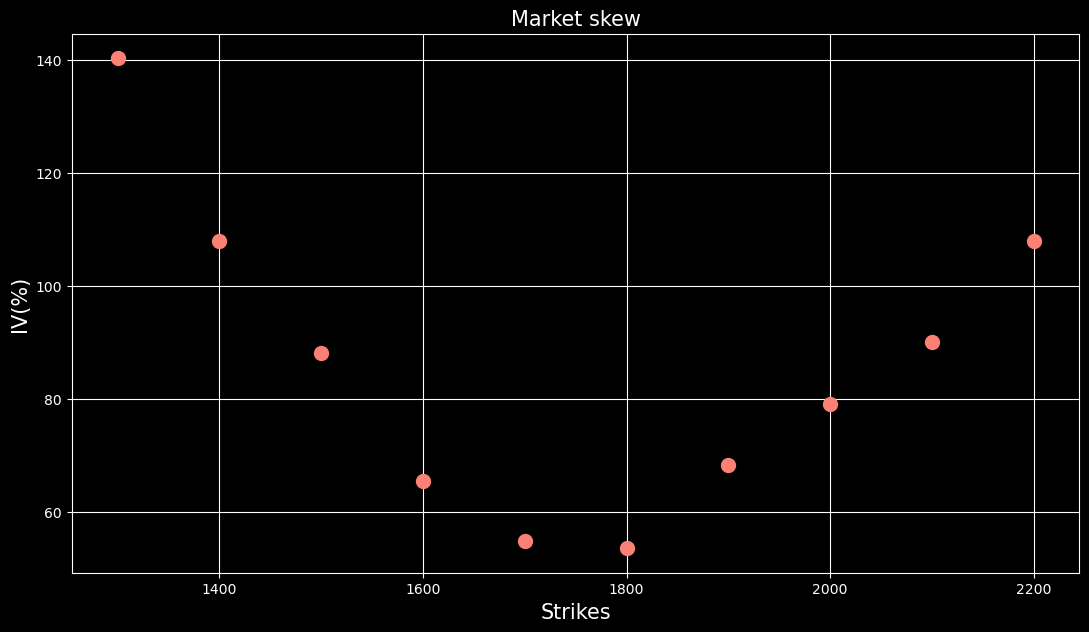

In [29]:
plt.figure(figsize=(13, 7))
plt.plot(strikes, 100*implied_vols, '.C3', markersize=20)
plt.title('Market skew', fontsize=15)
plt.xlabel('Strikes', color='white', fontsize=15)
plt.ylabel('IV(%)', color='white', fontsize=15)
plt.grid()
plt.show()

## 2. Levenberg-Marquardt algorithm

The Levenberg-Marquardt algorithm combines two numerical minimization algorithms: the gradient descent method and the
Gauss-Newton method. In the gradient descent method, the sum of the squared errors is reduced by updating the parameters in the steepest-descent direction. In the
Gauss-Newton method, the sum of the squared errors is reduced by assuming the least
squares function is locally quadratic in the parameters, and finding the minimum of
this quadratic. The Levenberg-Marquardt method acts more like a gradient-descent
method when the parameters are far from their optimal value, and acts more like the
Gauss-Newton method when the parameters are close to their optimal value.

["The Levenberg-Marquardt algorithm for
nonlinear least squares curve-fitting problems" Henri P. Gavin 2022](https://people.duke.edu/~hpgavin/ExperimentalSystems/lm.pdf)

##### Levenberg-Marquardt

$$
\chi^2(\boldsymbol{\theta}) =(\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}}(\boldsymbol{\theta}))^{\top} \boldsymbol{W}(\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}}(\boldsymbol{\theta}));
$$

$$ W_{ii} = \frac{1}{w_i^2}, \quad \sigma = [\sigma_i], \quad \hat{\sigma} = [\hat{\sigma_i}] $$

##### Gradient descent

$$
\begin{aligned}
\frac{\partial}{\partial \boldsymbol{\theta}} \chi^2 & =-2(\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}})^{\top} \boldsymbol{W} \boldsymbol{J}; \quad \boldsymbol{J} = \left[\frac{\partial \hat{\boldsymbol{y}}(\boldsymbol{p})}{\partial \boldsymbol{p}}\right]
\end{aligned}
$$

$$ \text{step: } h_g = \lambda \boldsymbol{J}^T \boldsymbol{W} (\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}}); \quad \lambda > 0 \text{ - learning rate} $$

##### Gauss-Newton Method  $ \quad |h| << 1 $

$$\hat{\boldsymbol{\sigma}}(\boldsymbol{\theta}+\boldsymbol{h}) \approx \hat{\boldsymbol{\sigma}}(\boldsymbol{\theta})+\boldsymbol{J} \boldsymbol{h}$$

Note the approximations:
$$
\chi^2(\boldsymbol{\theta}+\boldsymbol{h}) \approx \boldsymbol{\sigma}^{\top} \boldsymbol{W} \boldsymbol{\sigma}+\hat{\boldsymbol{\sigma}}^{\top} \boldsymbol{W} \hat{\boldsymbol{\sigma}}-2 \boldsymbol{\sigma}^{\top} \boldsymbol{W} \hat{\boldsymbol{\sigma}}-2(\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}})^{\top} \boldsymbol{W} \boldsymbol{J} \boldsymbol{h}+\boldsymbol{h}^{\top} \boldsymbol{J}^{\top} \boldsymbol{W} \boldsymbol{J} \boldsymbol{h}
$$
so that
$$
\frac{\partial}{\partial \boldsymbol{h}} \chi^2(\boldsymbol{\theta}+\boldsymbol{h}) \approx-2(\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}})^{\top} \boldsymbol{W} \boldsymbol{J}+2 \boldsymbol{h}^{\top} \boldsymbol{J}^{\top} \boldsymbol{W} \boldsymbol{J}
$$

Hence the optimal step:
$$
\left[\boldsymbol{J}^{\top} \boldsymbol{W} \boldsymbol{J}\right] \boldsymbol{h}_{\mathrm{gn}}=\boldsymbol{J}^{\top} \boldsymbol{W}(\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}})
$$

##### Levenberg Equation

$$
\left[\boldsymbol{J}^{\top} \boldsymbol{W} \boldsymbol{J}+\lambda \boldsymbol{I}\right] \boldsymbol{h}_{\mathrm{lm}}=\boldsymbol{J}^{\top} \boldsymbol{W}(\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}})
$$

##### Levenberg-Marquardt equation

$$
\left[\boldsymbol{J}^{\top} \boldsymbol{W} \boldsymbol{J}+\lambda \operatorname{diag}\left(\boldsymbol{J}^{\top} \boldsymbol{W} \boldsymbol{J}\right)\right] \boldsymbol{h}_{\mathrm{Im}}=\boldsymbol{J}^{\top} \boldsymbol{W}(\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}})
$$

##### Improvement metric

If using LM equation:
$$
\boldsymbol{\mu}(\boldsymbol{h}_{\mathrm{lm}}) = \frac{\chi^2(\boldsymbol{\theta})-\chi^2\left(\boldsymbol{\theta}+\boldsymbol{h}_{\mathrm{lm}}\right)}{\boldsymbol{h}_{\mathrm{lm}}^{\top}\left(\lambda \operatorname{diag}\left(\boldsymbol{J}^{\top} \boldsymbol{W} J\right) \boldsymbol{h}_{\mathrm{lm}}+\boldsymbol{J}^{\top} \boldsymbol{W}(\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}}(\boldsymbol{\theta}))\right)}
$$


$$
\mu << 1 \quad \rightarrow \quad \text{Gradient descent mode} \quad (\boldsymbol{\lambda} \text{ - is increasing})
$$

$$
\mu >> 1 \quad \rightarrow \quad \text{Gauss-Newton mode } \quad (\boldsymbol{\lambda} \text{ - is decreasing})
$$

##### Step procedure

$$ \boldsymbol{\lambda} = 10^{-2}  \quad \quad L_{\downarrow} = 2 \quad \quad L_{\uparrow} = 2 \quad \quad \boldsymbol{\epsilon} = 10^{-1} $$

$$ \text{solve the L-M equation with} \boldsymbol{\lambda} \quad \rightarrow \quad \boldsymbol{h}_{\mathrm{lm}} $$

$$
\begin{aligned}
& \text{if } \quad \boldsymbol{\mu}(\boldsymbol{h}_{\mathrm{lm}}) > \boldsymbol{\epsilon}: \\
& \quad \quad \boldsymbol{\theta} = \boldsymbol{\theta} + \boldsymbol{h}_{\mathrm{lm}} \\
& \quad \quad \boldsymbol{\lambda} = \max (\frac{\lambda}{L_{\downarrow}}, 10^{-7}) \\
& \text{else: } \\
&  \quad \quad \boldsymbol{\lambda} = \min (\lambda L_{\uparrow} , 10^{7})
\end{aligned}
$$

##### Convergence Criteria

- Gradient convergence: $\left|\boldsymbol{J}^{\top} \boldsymbol{W}(\boldsymbol{\sigma}-\hat{\boldsymbol{\sigma}})\right|< 10^{-3}$;
- Parameters convergence: $\max \left|h_i / p_i\right|<10^{-3} ;$ or
- Convergence in $\chi^2:$ uses the value of the reduced $\chi^2, \chi_\nu^2=\chi^2 /(m-n+1)$, where $n$ - sample size, $m$ - param. dimension.

##### Error analysis

$$ \chi_\nu^2 >> 1 \text{ - poor fit };  \quad \chi_\nu^2 \approx 1 \text{ - fit error of same order as measurement error }; \quad \chi_\nu^2 << 1 \text{ - overfit }; $$

$$ \text{parameters covariance: } (\boldsymbol{J}^{\top} \boldsymbol{W} \boldsymbol{J})^{-1} $$

## 3. SABR calibration

This is a stochastic volatility model that describes the dynamics of the forward directly in the risk neutral measure:

$$ df_t = \alpha_t f_t^{\beta} dW_t^1 $$ 

$$ d \alpha_t = v \alpha_t dW_t^2$$ 

$$E[dW_t^1, dW_t^2] = \rho dt$$

where $-1 < \rho < 1$ is the vol correlation, $0 \leq \beta \leq 1$ is the CIR exponent and the Wiener processes are independent.

Hagan derived an asymptotic formula for implied volatility as $T \rightarrow 0$:

$$
\sigma_B(x, T) =I_B^0(x) \left(1 + I_H^1(x)T\right) + \mathcal{O}(T^2), \quad x = \ln \frac{f}{K}
$$

Hagan's original formula has arbitrage for small strikes and large maturities, and is inconsistent as $\beta \rightarrow 1$ at order zero. 

For the corrected expression see the [symbolic calculations notebook](sym_gradient_sv.ipynb) or the [source code](pyquant/sabr.py).

For ATM we can approximate the formula as:
$$\sigma_{ATM} = \sigma_{B} (f, f) \approx  \frac{\alpha(1+[\frac{(1-\beta)^2}{24} \frac{\alpha^2}{(f)^{2-2\beta}} + \frac{\rho \beta v \alpha}{4(f)^{(1-\beta)}}+\frac{2-3\rho^2}{24}v^2]T)}{f^{1 - \beta}} $$

From there we see that the backbone $\beta$ should satisfy:

$$
\ln \sigma_{ATM} \approx \ln \alpha - (1 - \beta) \ln {f}
$$

and should be calibrated as such from regression on historical data. If quotes for $\sigma_{ATM}$ are not available, one can run regression on historical calibrations with $\beta \equiv 1$. 

#### Calibration test

In [30]:
from pyquant.sabr import *

In [31]:
vol_smile_chain = VolSmileChainSpace(
    forward,
    Strikes(strikes),
    ImpliedVols(implied_vols)
)

In [32]:
backbone = Backbone(0.95)
weights = CalibrationWeights(np.ones_like(vol_smile_chain.Ks))

In [33]:
sabr_calc = SABRCalc()

In [34]:
calibrated_params, error = sabr_calc.calibrate(vol_smile_chain, backbone, weights)
calibrated_params.array()

array([ 0.6635055 , -0.19860312, 10.53338346])

In [35]:
test_strikes = Strikes(np.linspace(strikes[0], strikes[-1], 100))
test_iv = sabr_calc.implied_vols(vol_smile_chain.forward(), test_strikes, calibrated_params)
delta_space_chain = sabr_calc.delta_space(forward, calibrated_params).to_chain_space()

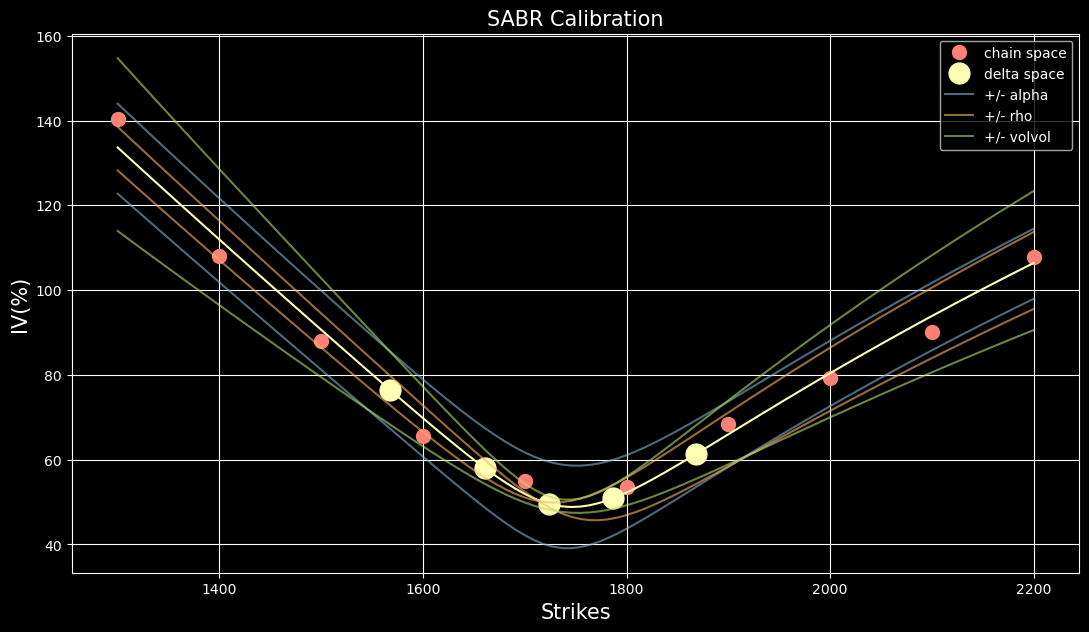

In [36]:
plt.figure(figsize=(13, 7))
plt.plot(strikes, 100*implied_vols, '.C3', markersize=20,  label='chain space')

plt.plot(test_strikes.data, 100*test_iv.data, 'C1')
plt.plot(delta_space_chain.Ks, 100*delta_space_chain.sigmas, '.C1', markersize=30, label='delta space')

plt.plot(test_strikes.data, 
         100*sabr_calc.implied_vols(vol_smile_chain.forward(), test_strikes, calibrated_params.scale_alpha(1.2)).data,
         'C4', label='+/- alpha', alpha=0.6)
plt.plot(test_strikes.data, 
         100*sabr_calc.implied_vols(vol_smile_chain.forward(), test_strikes, calibrated_params.scale_alpha(0.8)).data,
         'C4', alpha=0.6)

plt.plot(test_strikes.data, 
         100*sabr_calc.implied_vols(vol_smile_chain.forward(), test_strikes, calibrated_params.scale_rho(2)).data,
         'C5', label='+/- rho', alpha=0.6)
plt.plot(test_strikes.data, 
         100*sabr_calc.implied_vols(vol_smile_chain.forward(), test_strikes, calibrated_params.scale_rho(0.2)).data,
         'C5', alpha=0.6)


plt.plot(test_strikes.data, 
         100*sabr_calc.implied_vols(vol_smile_chain.forward(), test_strikes, calibrated_params.scale_v(1.2)).data,
         'C6', label='+/- volvol', alpha=0.6)
plt.plot(test_strikes.data, 
         100*sabr_calc.implied_vols(vol_smile_chain.forward(), test_strikes, calibrated_params.scale_v(0.8)).data,
         'C6', alpha=0.6)


plt.title('SABR Calibration', fontsize=15)
plt.xlabel('Strikes', color='white', fontsize=15)
plt.ylabel('IV(%)', color='white', fontsize=15)
plt.grid()
plt.legend(fontsize=10)
plt.show()

#### SABR greeks
Letting $PV = PV_B(\sigma_B)$ to be the present value of a call option (premium), with $PV_B$ denoting the Black-Scholes formula and $\sigma_B$ SABR implied vol. 
The forward value is:
$$
FV =\frac{PV}{D}
$$
where $D$ is our numeraire (or discounting), so that the spot is $S = D \cdot f$

The SABR greeks are given below in terms of Black-Scholes-Merton greeks:

* Sticky Delta (for the call):
$$\Delta_C =  \frac{\partial PV}{\partial S} =  \frac{1}{D}\frac{\partial PV}{\partial f} =  \frac{1}{D}\frac{\partial PV_B}{\partial f} + \frac{1}{D}\frac{\partial PV_B}{\partial \sigma_B} \cdot \left( \frac{\partial \sigma_B}{\partial f} + \frac{\partial \sigma_B}{\partial \alpha}  \frac{\rho v}{f^\beta} \right) = $$
$$ = \Delta_{C,BSM} + \frac{1}{D}\mathcal{V}_{BSM} \cdot \left( \frac{\partial \sigma_B}{\partial f} + \frac{\partial \sigma_B}{\partial \alpha}  \frac{\rho v}{f^\beta} \right)$$
Note that for sticky strike one lets:
$$
\frac{\partial \sigma_B}{\partial \alpha} = 0.
$$
Hence only infinitesimal changes in $f$ are considered ingnoring the correlation with $\alpha$.

For the put one can use the put-call parity:
$$\Delta_{P} = \Delta_{C} - 1$$

* Gamma: 
$$
\Gamma = \frac{\partial \Delta_C}{\partial S} = \frac{\partial \Delta_P}{\partial S}  = \frac{1}{D}\frac{\partial \Delta_C}{\partial f}
$$

$$
= \Gamma_{BSM} + \frac{2}{D}\text{Vanna}_{BSM} \cdot \left( \frac{\partial \sigma_B}{\partial f} + \frac{\partial \sigma_B}{\partial \alpha}  \frac{\rho v}{f^\beta} \right) 
$$

$$
+  \frac{1}{D^2}\text{Volga}_{BSM}\cdot \left( \frac{\partial \sigma_B}{\partial f} + \frac{\partial \sigma_B}{\partial \alpha}  \frac{\rho v}{f^\beta} \right) ^2
$$

$$
+ \frac{1}{D^2} \mathcal{V}_{BSM} \cdot \left( \frac{\partial ^2 \sigma_B}{\partial f^2} + \frac{\partial ^2 \sigma_B}{\partial \alpha \partial f}  \frac{\rho v}{f^\beta}  - \frac{\partial \sigma_B}{\partial \alpha}  \frac{\beta \rho v}{f^{\beta + 1}} \right)
$$

For sticky strike one lets:
$$
\frac{\partial \sigma_B}{\partial \alpha} = \frac{\partial ^2 \sigma_B}{\partial \alpha \partial f} = 0 
$$
above.

* Vega (ATM straddle):

$$
\mathcal{V} = \frac{\partial PV}{\partial \alpha} 
$$
$$
= \mathcal{V}_{BSM} \cdot \left( 
 \frac{\partial \sigma_B}{\partial \alpha} + \frac{\partial \sigma_B}{\partial f} \cdot \frac{\rho f^\beta}{v}\right)
$$
with sticky strike one sets $ \partial \sigma_B /\partial f = 0.$
 
 * Rega (risk reversal):
 $$ \mathcal{R} =\frac{ \partial PV}{\partial  \rho} = \mathcal{V}_{BSM} \frac{\partial \sigma_B}{\partial \rho}$$

 * Sega (butterfly):
$$ \mathcal{S} =\frac{ \partial PV}{\partial  v} = \mathcal{V}_{BSM} \frac{\partial \sigma_B}{\partial v}$$

* Vanna: 
$$
\mathcal{Vanna} = \frac{\partial \mathcal{V}}{\partial S } =\frac{1}{D} \frac{\partial \mathcal{V}}{\partial f }
$$
$$
= \left( \text{Vanna}_{BSM} + \frac{1}{D} \text{Volga}_{BSM}\cdot \left( \frac{\partial \sigma_B}{\partial f} + \frac{\partial \sigma_B}{\partial \alpha}  \frac{\rho v}{f^\beta} \right) \right)\cdot \left( 
 \frac{\partial \sigma_B}{\partial \alpha} + \frac{\partial \sigma_B}{\partial f} \cdot \frac{\rho f^\beta}{v}\right)
$$
$$
+ \frac{1}{D}\mathcal{V}_{BSM} \cdot \left( \frac{\partial ^2 \sigma_B}{\partial f \partial \alpha} + \frac{\partial ^2 \sigma_B}{\partial f^2}  \frac{\rho f^\beta}{v}  + \frac{\partial \sigma_B}{\partial f}  \frac{\beta \rho f^{\beta - 1}}{v} \right)
$$

with sticky strike one gets:
$$
\mathcal{Vanna} = \left( \text{Vanna}_{BSM} + \frac{1}{D} \text{Volga}_{BSM} \cdot \frac{\partial \sigma_B}{\partial f} \right) \cdot  \frac{\partial \sigma_B}{\partial \alpha} + \frac{1}{D}\mathcal{V}_{BSM} \cdot \frac{\partial ^2 \sigma_B}{\partial f \partial \alpha}  
$$


* Volga: 
$$
\mathcal{Volga} = \frac{\partial \mathcal{V}}{\partial \alpha }
$$
$$
= \text{Volga}_{BSM} \cdot \left( 
 \frac{\partial \sigma_B}{\partial \alpha} + \frac{\partial \sigma_B}{\partial f} \cdot \frac{\rho f^\beta}{v}\right)^2
$$
$$
+ \mathcal{V}_{BSM} \cdot \left( \frac{\partial ^2 \sigma_B}{\partial \alpha^2} + \frac{\partial ^2 \sigma_B}{\partial f \partial \alpha}  \cdot \frac{\rho f^\beta}{v} \right)
$$
with sticky strike one lets:
$$
 \frac{\partial \sigma_B}{\partial f}  = \frac{\partial ^2 \sigma_B}{\partial f \partial \alpha} = 0
$$

#### Delta space
Mapping from delta space:
$$
g(K) = \Delta_{BSM} - \delta \equiv 0 
$$
with implied volatility constrained by SABR is achieved computing the smile sensitivity to the strike:
$$
g'(K) = \frac{N'(d_1)}{\sqrt T} \left( -\frac{1}{K\sigma(K)} - \frac{\sigma'(K) \ln \frac{S}{K}}{\sigma^2(K)} - \frac{rT\sigma'(K)}{\sigma^2(K)} + T\sigma'(K)    \right)
$$

##### Example 1: ATM Straddle

In [38]:
atm_straddle = SingleMaturityVanillas(
            OptionTypes(np.array([False, True])), 
            Strikes(np.array([delta_space_chain.Ks[2], delta_space_chain.Ks[2]])), 
            Notionals(np.array([1000.,1000.])), 
            vol_smile_chain.time_to_maturity()
        )
atm_straddle.Ks

array([1723.92238362, 1723.92238362])

In [39]:
from importlib import reload
import pyquant.sabr
reload(pyquant.sabr)
from pyquant.sabr import *

In [40]:
def sabr_risk(portfolio, vol_smile_chain, calibrated_params):
    bs_calc = BSCalc()
    sabr_calc = SABRCalc()
    forward = vol_smile_chain.forward()
    
    ivs = sabr_calc.implied_vols(forward, portfolio.strikes(), calibrated_params)

    df = pd.DataFrame({
        'present_value': sabr_calc.premiums(forward, portfolio, calibrated_params).data,
        'notional': portfolio.Ns,
        'call': portfolio.is_call,
        'strike': portfolio.Ks,
        'implied_vol': ivs.data,
        
        'delta': bs_calc.deltas(forward, portfolio, ivs).data,
        'sticky_delta': sabr_calc.sticky_deltas(forward, portfolio, calibrated_params, StickyStrike(False)).data,
        'strike_delta': sabr_calc.sticky_deltas(forward, portfolio, calibrated_params, StickyStrike(True)).data,

        'vega': bs_calc.vegas(forward, portfolio, ivs).data,
        'blip_vega': sabr_calc.blip_vegas(forward, portfolio, calibrated_params).data,
        'sticky_vega': sabr_calc.sticky_vegas(forward, portfolio, calibrated_params, StickyStrike(False)).data,
        'strike_vega': sabr_calc.sticky_vegas(forward, portfolio, calibrated_params, StickyStrike(True)).data,

        'blip_rega': sabr_calc.blip_regas(forward, portfolio, calibrated_params).data,
        'rho_rega': sabr_calc.regas_rho(forward, portfolio, calibrated_params).data,
        
        'blip_sega': sabr_calc.blip_segas(forward, portfolio, calibrated_params).data,        
        'volvol_sega': sabr_calc.segas_volvol(forward, portfolio, calibrated_params).data,

        'gamma': bs_calc.gammas(forward, portfolio, ivs).data,
        'sticky_gamma': sabr_calc.sticky_gammas(forward, portfolio, calibrated_params, StickyStrike(False)).data,
        'strike_gamma': sabr_calc.sticky_gammas(forward, portfolio, calibrated_params, StickyStrike(True)).data,
        
        
        'volga': bs_calc.volgas(forward, portfolio, ivs).data,
        'sticky_volga': sabr_calc.sticky_volgas(forward, portfolio, calibrated_params, StickyStrike(False)).data,
        'strike_volga': sabr_calc.sticky_volgas(forward, portfolio, calibrated_params, StickyStrike(True)).data,
        
        'vanna': bs_calc.vannas(forward, portfolio, ivs).data,
        'sticky_vanna': sabr_calc.sticky_vannas(forward, portfolio, calibrated_params, StickyStrike(False)).data,
        'strike_vanna': sabr_calc.sticky_vannas(forward, portfolio, calibrated_params, StickyStrike(True)).data
    })
    return df, df.drop(columns=['notional','call','strike', 'implied_vol']).sum()
    
    

In [41]:
leg_risk, total_risk = sabr_risk(atm_straddle, vol_smile_chain, calibrated_params)

In [42]:
leg_risk

,present_value,notional,call,strike,implied_vol,delta,sticky_delta,strike_delta,vega,blip_vega,sticky_vega,strike_vega,blip_rega,rho_rega,blip_sega,volvol_sega,gamma,sticky_gamma,strike_gamma,volga,sticky_volga,strike_volga,vanna,sticky_vanna,strike_vanna
0,34093.99,1000.0,False,1723.92,0.5,-490.11,-580.42,-490.11,4.67,70079.49,51266.29,51266.32,3539.99,2090.49,18676.06,512.26,4.67,4.67,4.72,-85.22,-371.59,-371.52,-1.99,-1.4,-1.48
1,34093.99,1000.0,True,1723.92,0.5,509.89,419.58,509.89,4.67,70079.49,51266.29,51266.32,3539.99,2090.49,18676.06,512.26,4.67,4.67,4.72,-85.22,-371.59,-371.52,-1.99,-1.4,-1.48


In [43]:
total_risk

present_value     68187.97
delta                19.78
sticky_delta       -160.84
strike_delta         19.78
vega                  9.33
blip_vega        140158.98
sticky_vega      102532.59
strike_vega      102532.63
blip_rega          7079.98
rho_rega           4180.98
blip_sega         37352.11
volvol_sega        1024.53
gamma                 9.33
sticky_gamma          9.33
strike_gamma          9.44
volga              -170.43
sticky_volga       -743.18
strike_volga       -743.04
vanna                -3.99
sticky_vanna         -2.80
strike_vanna         -2.97
dtype: float64

##### Example 2: Risk Reversal

In [44]:
risk_reversal_10 = SingleMaturityVanillas(
            OptionTypes(np.array([False, True])), 
            Strikes(np.array([delta_space_chain.Ks[0], delta_space_chain.Ks[-1]])), 
            Notionals(np.array([-1000.,1000.])), 
            vol_smile_chain.time_to_maturity()
        )
risk_reversal_10.Ks

array([1567.58712995, 1868.49018987])

In [45]:
leg_risk_rr, total_risk_rr = sabr_risk(risk_reversal_10, vol_smile_chain, calibrated_params)

In [46]:
leg_risk_rr

,present_value,notional,call,strike,implied_vol,delta,sticky_delta,strike_delta,vega,blip_vega,sticky_vega,strike_vega,blip_rega,rho_rega,blip_sega,volvol_sega,gamma,sticky_gamma,strike_gamma,volga,sticky_volga,strike_volga,vanna,sticky_vanna,strike_vanna
0,-6443.72,-1000.0,False,1567.59,0.76,100.0,79.81,43.29,-1.33,-18120.84,-19463.05,-20732.80,16768.97,6101.33,-47740.39,-1232.92,-1.33,-1.61,-1.37,-61103.81,-24413.33,-27873.58,-27.66,-46.66,-99.80
1,4883.29,1000.0,True,1868.49,0.61,100.0,20.50,52.09,1.66,19086.13,19007.59,17934.95,16108.41,9812.50,49836.30,908.03,1.66,2.09,2.54,84838.91,36206.05,32867.81,-38.40,-150.88,-87.45


In [47]:
total_risk_rr

present_value    -1560.43
delta              200.00
sticky_delta       100.31
strike_delta        95.39
vega                 0.33
blip_vega          965.29
sticky_vega       -455.46
strike_vega      -2797.85
blip_rega        32877.38
rho_rega         15913.83
blip_sega         2095.91
volvol_sega       -324.89
gamma                0.33
sticky_gamma         0.49
strike_gamma         1.17
volga            23735.10
sticky_volga     11792.72
strike_volga      4994.23
vanna              -66.07
sticky_vanna      -197.55
strike_vanna      -187.25
dtype: float64

##### Example 3: Vega Neutral Butterfly

In [48]:
butterfly_10 = SingleMaturityVanillas(
            OptionTypes(np.array([False, False, True, True])), 
            Strikes(np.array([delta_space_chain.Ks[0], delta_space_chain.Ks[2], delta_space_chain.Ks[2], delta_space_chain.Ks[-1]])), 
            Notionals(np.array([1000.,-1000., -1000., 1000.])), 
            vol_smile_chain.time_to_maturity()
        )
butterfly_10.Ks

array([1567.58712995, 1723.92238362, 1723.92238362, 1868.49018987])

In [49]:
ivs = np.array([delta_space_chain.sigmas[0], delta_space_chain.sigmas[2], delta_space_chain.sigmas[2], delta_space_chain.sigmas[-1]])
vegas = bs_calc.vegas(forward, butterfly_10, ImpliedVols(ivs))
vegas.data

array([ 1.33156808, -4.66623365, -4.66623365,  1.65905338])

In [50]:
ivs = np.array([delta_space_chain.sigmas[0], delta_space_chain.sigmas[2], delta_space_chain.sigmas[2], delta_space_chain.sigmas[-1]])
vegas = bs_calc.vegas(forward, butterfly_10, ImpliedVols(ivs))
butterfly_10.Ns[1:-1] = (vegas.data[0] + vegas.data[-1])  / (-2*vegas.data[1]) * butterfly_10.Ns[1:-1]
butterfly_10.Ns

array([1000.        , -320.45346277, -320.45346277, 1000.        ])

In [51]:
leg_risk_bb, total_risk_bb = sabr_risk(butterfly_10, vol_smile_chain, calibrated_params)

In [52]:
leg_risk_bb

,present_value,notional,call,strike,implied_vol,delta,sticky_delta,strike_delta,vega,blip_vega,sticky_vega,strike_vega,blip_rega,rho_rega,blip_sega,volvol_sega,gamma,sticky_gamma,strike_gamma,volga,sticky_volga,strike_volga,vanna,sticky_vanna,strike_vanna
0,6443.72,1000.00,False,1567.59,0.76,-100.00,-79.81,-43.29,1.33,18120.84,19463.05,20732.80,-16768.97,-6101.33,47740.39,1232.92,1.33,1.61,1.37,61103.81,24413.33,27873.58,27.66,46.66,99.80
1,-10925.54,-320.45,False,1723.92,0.50,157.06,186.00,157.06,-1.50,-22457.21,-16428.46,-16428.47,-1134.40,-669.90,-5984.81,-164.16,-1.50,-1.50,-1.51,27.31,119.08,119.06,0.64,0.45,0.48
2,-10925.54,-320.45,True,1723.92,0.50,-163.40,-134.46,-163.40,-1.50,-22457.21,-16428.46,-16428.47,-1134.40,-669.90,-5984.81,-164.16,-1.50,-1.50,-1.51,27.31,119.08,119.06,0.64,0.45,0.48
3,4883.29,1000.00,True,1868.49,0.61,100.00,20.50,52.09,1.66,19086.13,19007.59,17934.95,16108.41,9812.50,49836.30,908.03,1.66,2.09,2.54,84838.91,36206.05,32867.81,-38.40,-150.88,-87.45


In [53]:
total_risk_bb.round(2)

present_value    -10524.06
delta                -6.34
sticky_delta         -7.77
strike_delta          2.46
vega                  0.00
blip_vega         -7707.46
sticky_vega        5613.71
strike_vega        5810.82
blip_rega         -2929.37
rho_rega           2371.37
blip_sega         85607.07
volvol_sega        1812.64
gamma                 0.00
sticky_gamma          0.71
strike_gamma          0.88
volga            145997.33
sticky_volga      60857.54
strike_volga      60979.51
vanna                -9.47
sticky_vanna       -103.32
strike_vanna         13.31
dtype: float64

#### Warm starting

In [54]:
new_forward = 1723.25
new_pvs = np.array([ 0.861625,  1.72325 ,  3.4465  ,  6.893   , 26.710375,
                    11.201125,  4.308125,  1.72325 ,  1.72325 ,  0.861625])

In [55]:
new_implied_vols = bs_calc.implied_vols(
    Forward(Spot(new_forward), ForwardYield(0.), TimeToMaturity(tau)),
    Strikes(strikes),
    Premiums(new_pvs)
).data

In [56]:
new_vol_smile_chain = VolSmileChainSpace(
    Forward(Spot(new_forward), ForwardYield(0.), TimeToMaturity(tau)),
    Strikes(strikes),
    ImpliedVols(new_implied_vols)
)

In [57]:
sabr_calc.update_cached_params(calibrated_params)

In [58]:
new_calibrated_params, error = sabr_calc.calibrate(new_vol_smile_chain, backbone, weights)
print(error.v)
new_calibrated_params.array()

4.194735422631363e-06


array([ 0.68052445, -0.10442946, 10.09085493])

#### BSM limit

In [63]:
flat_implied_vols = np.ones_like(implied_vols)*0.8
flat_vol_smile_chain = VolSmileChainSpace(
    Forward(Spot(new_forward), ForwardYield(0.), TimeToMaturity(tau)),
    Strikes(strikes),
    ImpliedVols(flat_implied_vols)
)
sabr_calc.update_cached_params(
    SABRParams(Volatility(1.), Correlation(0.), VolOfVol(0.), Backbone(1.0))
)
flat_calibrated_params, error = sabr_calc.calibrate(flat_vol_smile_chain, Backbone(1.0), weights)
print(error.v)
flat_calibrated_params.array()

9.709601923393768e-13


array([ 8.00009854e-01, -4.74409985e-06,  1.00000000e-04])

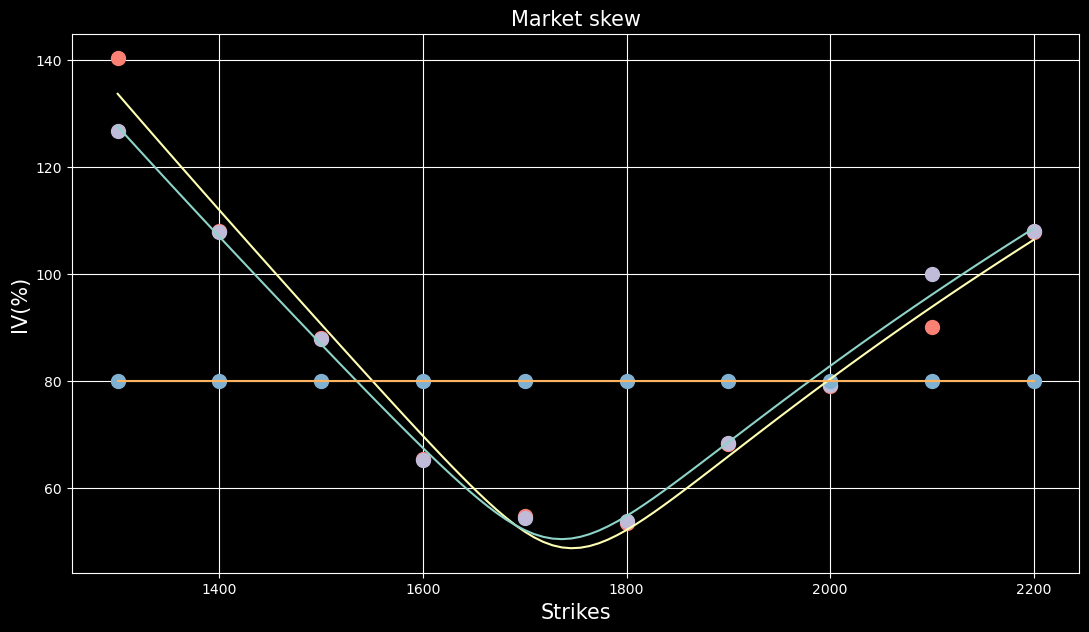

In [62]:
flat_test_iv = sabr_calc.implied_vols(
    Forward(Spot(new_forward), ForwardYield(0.), TimeToMaturity(tau)),
    test_strikes,
    flat_calibrated_params
)
new_test_iv = sabr_calc.implied_vols(
    Forward(Spot(new_forward), ForwardYield(0.), TimeToMaturity(tau)),
    test_strikes,
    new_calibrated_params
)
plt.figure(figsize=(13, 7))
plt.plot(strikes, 100*implied_vols, '.C3', markersize=20)
plt.plot(strikes, 100*new_implied_vols, '.C2', markersize=20)
plt.plot(strikes, 100*flat_implied_vols, '.C4', markersize=20)
plt.plot(test_strikes.data, 100*test_iv.data, 'C1')
plt.plot(test_strikes.data, 100*new_test_iv.data, 'C0')
plt.plot(test_strikes.data, 100*flat_test_iv.data, 'C5')
plt.title('Market skew', fontsize=15)
plt.xlabel('Strikes', color='white', fontsize=15)
plt.ylabel('IV(%)', color='white', fontsize=15)
plt.grid()
plt.show()

#### Hagan's original formula

In [64]:
def hagan_implied_volatility(K,T,f,alpha,beta,rho,gamma):
    z        = gamma/alpha*np.power(f*K,(1.0-beta)/2.0)*np.log(f/K);
    x_z      = np.log((np.sqrt(1.0-2.0*rho*z+z*z)+z-rho)/(1.0-rho))
    A        = alpha/(np.power(f*K,((1.0-beta)/2.0))*(1.0+np.power(1.0-beta,2.0)/24.0*
                               np.power(np.log(f/K),2.0)+np.power((1.0-beta),4.0)/1920.0*
                               np.power(np.log(f/K),4.0)))
    B1       = 1.0 + (np.power((1.0-beta),2.0)/24.0*alpha*alpha/(np.power((f*K),
                1-beta))+1/4*(rho*beta*gamma*alpha)/(np.power((f*K),
                             ((1.0-beta)/2.0)))+(2.0-3.0*rho*rho)/24.0*gamma*gamma)*T
    impVol   = A*(z/x_z) * B1
    B2 = 1.0 + (np.power(1.0-beta,2.0)/24.0*alpha*alpha/
                (np.power(f,2.0-2.0*beta))+1.0/4.0*(rho*beta*gamma*
                alpha)/np.power(f,(1.0-beta))+(2.0-3.0*rho*rho)/24.0*gamma*gamma)*T;


    impVol[np.where(K==f)] = alpha / np.power(f,(1-beta)) * B2;
    return impVol

In [65]:
for t in [1., .5, .01]:
    print(f'\n////////////// time to maturity = {t} ////////////////')
    for beta in [.5, .95,  1.]:
        print(f'============== beta = {beta} =================')
        for scale in [100., 5., 1.]:
            new_strikes = test_strikes.data / scale
            new_calibrated_params.beta = beta
            error = np.abs(
                sabr_calc.implied_vols(
                    Forward(Spot(new_forward), ForwardYield(0.), TimeToMaturity(t)),
                    Strikes(new_strikes),
                    new_calibrated_params).data\
                - hagan_implied_volatility(new_strikes, t, new_forward, 
                                 new_calibrated_params.alpha, beta, 
                                 new_calibrated_params.rho, new_calibrated_params.v)).max()
            print(f'min strike {new_strikes[0]}, max diff: {error}')
    new_calibrated_params.beta = backbone.beta


////////////// time to maturity = 1.0 ////////////////
============== beta = 0.5 =================
min strike 13.0, max diff: 11.217962436552092
min strike 260.0, max diff: 0.7743667833419785
min strike 1300.0, max diff: 0.003188417881014871
============== beta = 0.95 =================
min strike 13.0, max diff: 0.1771497389092218
min strike 260.0, max diff: 0.011797859267012711
min strike 1300.0, max diff: 5.381313879659899e-05
============== beta = 1.0 =================
min strike 13.0, max diff: 4.263256414560601e-14
min strike 260.0, max diff: 2.1316282072803006e-14
min strike 1300.0, max diff: 3.9968028886505635e-14

////////////// time to maturity = 0.5 ////////////////
============== beta = 0.5 =================
min strike 13.0, max diff: 6.209556719943617
min strike 260.0, max diff: 0.42862360121448795
min strike 1300.0, max diff: 0.0017648161195094048
============== beta = 0.95 =================
min strike 13.0, max diff: 0.09818785947435771
min strike 260.0, max diff: 0.0065

### Managing the vol surface with SABR
For different maturities SABR dynamics take place in different $T$-forward measures. Nevertheless the map to the vol smiles and the associated calibrated parameters: 
$$
T \rightarrow \sigma_i(K_i), \left( \alpha^T, \rho^T, v^T \right)
$$
is continuous in $T$. Therefore, after performing a calibration for each maturity $T_j$ separately, one can perform an interpolation for each of the three parameters $(\alpha^{T_j}, \rho^{T_j}, v^{T_j})$, via a cubic spline for example.
 
#### Calendar Arbitrage
The above approach might lead to **calendar arbitrage**: that is when for each moneyness level:

$$
k \equiv \log \frac{K}{f_{t,T}} 
$$

the map:
$$
T \rightarrow \sigma \left(T,K \right)^2T
$$
is not strictly increasing. The quantity on the RHS is called *total implied variance*. Note that for fixed $k$ the strike $K$ evolves as we move the maturity $T$ unless the forward yield is trivial.

#### Market data interpolation
As consequence, a safer approach is interpolation of the market data first. Interpolating the options chain accross maturities is challenging as each maturity typically would contain a different set of strikes. 

A better approach is to map the chain space to delta space. This is achieved by calibrating SABR to existing tenors and compute the ATM straddle, risk reversals and butterflies (as we did in the previous section). As those are now free of strikes on can interpolate each of them accross tenors separetely:
$$
T \rightarrow \sigma_{ATM}(T), \sigma_{\delta RR}(T), \sigma_{\delta BB} (T) 
$$
One should get also the forward curve $T \rightarrow f_{t,T}$. Those interpolations can be achieved with a cubic spline.

Then, given a new maturity date $T_0$ not available in the market data, one maps delta space quotes to the options chain back simply using Black-Scholes:
$$
\sigma_{ATM}(T_0), \sigma_{\delta RR}(T_0), \sigma_{\delta BB} (T_0) \rightarrow \sigma(T_0, K_{\delta,p}), \sigma(T_0, f_{t,T}), \sigma(T_0, K_{\delta,c})
$$
and calibrate SABR to it, getting $\alpha^{T_0}, \rho^{T_0}, v^{T_0}$.



#### Greeks on the surface

SABR greeks are computed according to each time to maturity separetely. For example, the vega of a calendar spread shorting a one-month call $PV_{C,1M}$ and buying a longer dated one, e.g. three-month $PV_{C,3M}$ is:
$$
\mathcal{V}_{PV_{C,3M}-PV_{C,1M}} = \frac{\partial PV_{C,3M}}{\partial \alpha_{3M}} - \frac{\partial PV_{C,1M}}{\partial \alpha_{1M}}
$$

Similarly for volga, rega and sega. 

For delta (and gamma for that matter), this calculation is easier as we just differentiate w.r.t. spot:
$$
\Delta_{PV_{C,3M}-PV_{C,1M}} = \frac{\partial PV_{C,3M}}{\partial S_t} - \frac{\partial PV_{C,1M}}{\partial S_t}
$$

Finally, vanna risk is defined as sensitivity of vega to spot, so it will read:
$$
\text{Vanna}_{PV_{C,3M}-PV_{C,1M}} = \frac{\partial}{\partial S_t}\mathcal{V}_{PV_{C,3M}-PV_{C,1M}} =  \frac{\partial^2 PV_{C,3M}}{\partial S_t \partial \alpha_{3M}} - \frac{\partial^2 PV_{C,1M}}{\partial S_t \partial \alpha_{1M}}
$$

#### Unexplained PnL 

Given the present values $PV_t$, $S_t$ and calibrated parameters $\alpha_t$, $\rho_t$ and $v_t$, we observe the next update in the market $PV_{t+1}$, $S_{t+1}$, calibrate $\alpha_{t+1}$, $\rho_{t+1}$ and $v_{t+1}$ and measure:

$$
PV_{t+1} - PV_t = \Delta_{PV_t} \cdot (f_{t+1} - f_t) + \frac{1}{2} \Gamma_{PV_t} \cdot(f_{t+1} - f_t)^2
$$
$$
+ \mathcal{V}_{PV_t}\cdot(\alpha_{t+1} - \alpha_t) + \mathcal{R}_{PV_t}\cdot(\rho_{t+1} - \rho_t) + \mathcal{S}_{PV_t}\cdot(v_{t+1} - v_t)
$$
$$
+ \frac{1}{2} \mathcal{Vanna}_{PV_t} \cdot (\alpha_{t+1} - \alpha_t) \cdot (f_{t+1} - f_t)   +  \frac{1}{2} \mathcal{Volga}_{PV_t} \cdot (\alpha_{t+1} - \alpha_t)^2
$$
$$
+ \text{Unexplained Forward PnL}
$$

In [1]:
from importlib import reload
import pyquant.sabr
reload(pyquant.sabr)

<module 'pyquant.sabr' from '/home/rolan/devspace/noa/docs/quant/pyquant/sabr.py'>

In [7]:
from pyquant.common import *
from pyquant.vol_surface import *
from pyquant.sabr import *

In [8]:
def get_vol_surface(test_file):
    df = pd.read_csv(test_file, header=[0,1], index_col=0)
    
    Ts = pd.DatetimeIndex(df.index).astype(int).values.squeeze()
    Ts = (Ts - Ts[0]) / YEAR_NANOS
    
    types_str, strikes_str = zip(*df.columns[2:].values)
    Ks = np.array([float(x) for x in strikes_str])
    option_types = np.array([True if x == 'call' else False for x in types_str])
    
    spot = Spot(df['swap'].values[0].item())
    df.iloc[:, 2:] *= spot.S
    
    Fs = df['futures'].values.squeeze()
    Fidx = np.nonzero(Fs)
    fwd_curve = ForwardCurve.from_forward_rates(spot, ForwardRates(Fs[Fidx]), TimesToMaturity(Ts[Fidx]))
    
    n_T = len(Ts) - 1
    buf_T = Ts[1:].repeat(len(Ks))
    buf_K = np.tile(Ks, n_T)
    buf_C = np.tile(option_types, n_T)
    buf_pv = df.values[1:,2:].flatten()
    pv_idx = np.nonzero(buf_pv)

    return VolSurfaceChainSpace(
        fwd_curve, 
        TimesToMaturity(buf_T[pv_idx]),
        Strikes(buf_K[pv_idx]),
        OptionTypes(buf_C[pv_idx]),
        Premiums(buf_pv[pv_idx])
    )

In [9]:
volsurface_chain = get_vol_surface('./deribit_vol_surface.csv')

In [12]:
sabr_calc = SABRCalc()
volsurface_delta = sabr_calc.surface_to_delta_space(volsurface_chain, Backbone(1.))

In [39]:
volsurface_delta.max_T

0.9099524353120243

In [47]:
test_T = np.linspace(volsurface_delta.min_T, volsurface_delta.max_T, num=100) 
test_fwd = volsurface_delta.FWD.forward_yields(TimesToMaturity(test_T)).data
test_atm = volsurface_delta.atm_quotes(TimesToMaturity(test_T)).data
test_rr25 = volsurface_delta.rr25_quotes(TimesToMaturity(test_T)).data
test_bf25 = volsurface_delta.bf25_quotes(TimesToMaturity(test_T)).data
test_rr10 = volsurface_delta.rr10_quotes(TimesToMaturity(test_T)).data
test_bf10= volsurface_delta.bf10_quotes(TimesToMaturity(test_T)).data

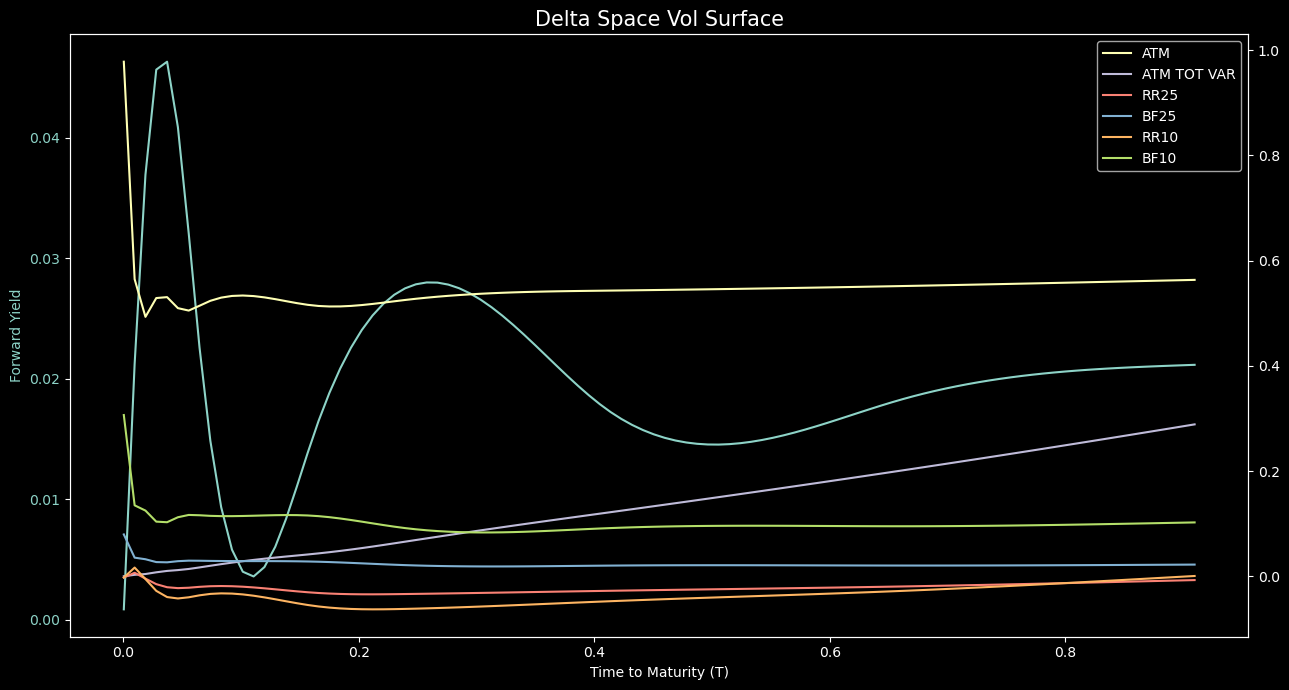

In [48]:
fig, ax1 = plt.subplots(figsize=(13, 7))

ax1.set_ylabel('Forward Yield', color='C0') 
ax1.set_xlabel('Time to Maturity (T)')
ax1.plot(test_T, test_fwd, 'C0')
ax1.tick_params(axis='y', labelcolor='C0')

ax2 = ax1.twinx() 
ax2.set_xlabel('Time to Maturity (T)')
ax2.plot(test_T, test_atm, 'C1', label='ATM')
ax2.plot(test_T, test_T*test_atm**2, 'C2', label='ATM TOT VAR')
ax2.plot(test_T, test_rr25, 'C3', label='RR25')
ax2.plot(test_T, test_bf25, 'C4', label='BF25')
ax2.plot(test_T, test_rr10, 'C5', label='RR10')
ax2.plot(test_T, test_bf10, 'C6', label='BF10')

plt.title('Delta Space Vol Surface', fontsize=15)
fig.tight_layout()
plt.legend()
plt.show()

In [49]:
test_K = np.linspace(np.min(volsurface_chain.Ks)*0.9, np.max(volsurface_chain.Ks)*1.1, num=100)
test_ivs = sabr_calc.surface_grid_ivs(volsurface_delta, Strikes(test_K), TimesToMaturity(test_T), Backbone(1.)).data

In [50]:
test_grid_K, test_grid_T = np.meshgrid(test_K, test_T)
test_grid_ivs = test_ivs.reshape(len(test_K), len(test_T))

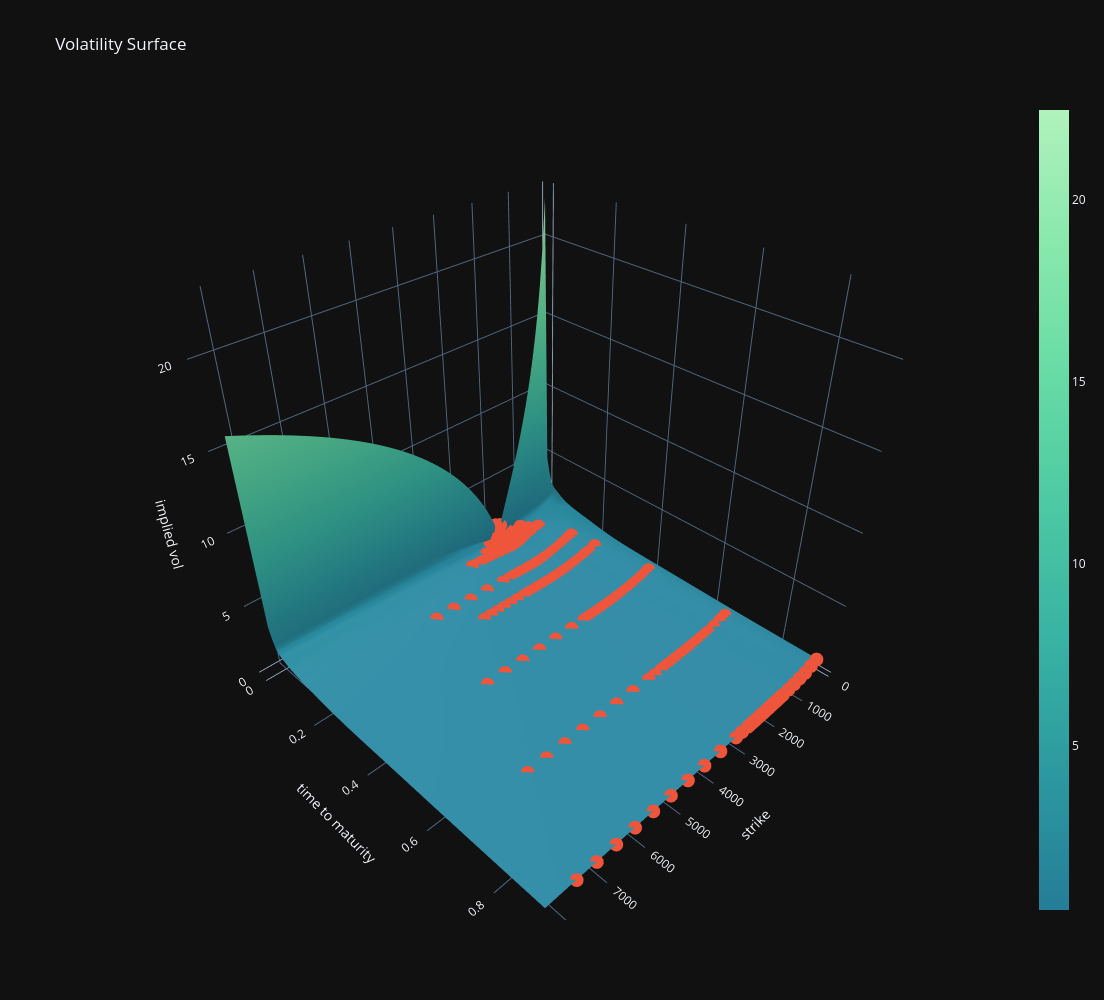

In [53]:
fig = go.Figure(data=[go.Surface(z=test_grid_ivs, x=test_grid_K,
                                 y=test_grid_T, colorscale='Tealgrn_r'),
                      go.Scatter3d(z=volsurface_chain.sigmas, x=volsurface_chain.Ks, y=volsurface_chain.Ts, mode='markers')
                     ])
fig.update_layout(title='Volatility Surface', template="plotly_dark", width=1000, height=1000)
fig.update_scenes(xaxis_title_text='strike',
                  yaxis_title_text='time to maturity',
                  zaxis_title_text='implied vol')
fig.show()

## 4. Heston calibration
This is a stochastic volatility model for the forward dynamics in the risk neutral measure, and CIR dynamics for the variance:
$$
\left\{
\begin{array}{l}
    \text{d}X_t =  \sqrt{V_t} X_t \text{d}W_t^X,  \\
    \text{d}V_t =  \kappa (\theta - V_t)\text{d}t + \varepsilon \sqrt{V_t} \text{d} W_t^V,
\end{array}\right.
$$

where underlying Brownian motions are correlated:
$$ \text{d} W_t^V = \rho\text{d}W_t^X + \sqrt{1-\rho^2} \text{d}W_t,$$
$$ -1 < \rho < 1. $$

The forward price of a call option is given by:
$$
\text{FV}_C(t_0, T, K) = X_{t_0} H(\sqrt{-1}) - K \cdot H(0)
$$
where
$$
H(z) = \frac{1}{2} + \frac{1}{\pi} \int^{\infty}_0 \mathbf{Re} \left[ \frac{e^{u\sqrt{-1} \log \frac{X_{t_0}}{K}}}{u\sqrt{-1}} \phi(u-z,T) \right]\text{d}u
$$
with 
$$
\phi(u,T) = \exp \left( - \frac{\kappa\theta\rho T u\sqrt{-1} }{\varepsilon} - A + \frac{2 \kappa \theta }{\varepsilon^2}D\right).
$$
Here $A = A_1 / A_2$:
$$
A_1 = (u^2 + u\sqrt{-1}) \sinh \frac{q T}{2}, \quad q = \sqrt{ \xi^2 + \varepsilon^2 (u^2 + u\sqrt{-1})}, \quad \xi = \kappa - \varepsilon\rho u\sqrt{-1},
$$
$$
\log A_2 = \frac{q T}{2} + \log \left( \frac{q +\xi}{2 V_{t_0}} + \frac{q  - \xi}{2V_{t_0}}e^{-q T}\right),
$$

and
$$
D = \log \frac{q}{V_{t_0}} + \frac{\kappa T}{2} - \log A_2.
$$

The integral above can be truncated to $(0,200)$ and evaluated via Gaussian quadrature at 64 nodes for $10^{-10}$ accuracy.

For semi-analytical gradient formulae w.r.t. to all model parameters see Cui et al. (2016)

#### 4.1 Delta computation
See that:

$$\text{FV}_C(\lambda X_{t_0}, T, \lambda K) = \lambda \text{FV}_C(X_{t_0}, T, K).$$

So, formula is homogeneous of order one. Differentiating both sides with respect to $\lambda$:

$$X_{t_0} \frac{\partial \text{FV}_C}{\partial X_{t_0}} + K \frac{\partial \text{FV}_C}{\partial K} = \text{FV}_C.$$

Comparing with equation for call-option:

$$\Delta = \frac{\partial \text{FV}_C}{\partial X_{t_0}} = H(i).$$

In [49]:
market_params = get_market_params(deribit_surface)
start_params=HestonParams(
    Variance(0.65),
    VarReversion(1.0),
    AverageVar(1.3),
    VolOfVar(1.0),
    Correlation(-0.4)
)
weights = CalibrationWeights(np.ones_like(market_params.premiums))
heston_calc = HestonCalc(start_params)
calibrated_params = heston_calc.calibrate(market_params, weights)

In [50]:
print('Calibrated params:')
print('    v0:', calibrated_params.v0)
print('    kappa:', calibrated_params.kappa)
print('    theta:', calibrated_params.theta)
print('    eps:', calibrated_params.eps)
print('    rho:', calibrated_params.rho)
print()
print('Calibration error:', heston_calc.calibration_error)

Calibrated params:
    v0: 0.3156451061682837
    kappa: 4.560263720290844
    theta: 0.43167029934375234
    eps: 3.4997546280644656
    rho: -0.11755055232920064

Calibration error: 0.00010075751717371302


#### Calculate the premiums using the calibrated model and compare them to the market

In [51]:
market_params_all = get_market_params_all(deribit_surface)

In [52]:
premiums_calculated_flat = heston_calc.premiums(
    spot,
    TimesToMaturity(market_params_all.T),
    Strikes(market_params_all.K),
    OptionTypes(market_params_all.types)
).data

premiums_calculated = premiums_calculated_flat.reshape(deribit_surface.iloc[:, 2:].shape)

**Calculated surface**

In [53]:
calculated_surface = deribit_surface.copy()
calculated_surface.iloc[:, 2:] = premiums_calculated
calculated_surface

swap  futures     put                          \
                          0        0     200    400    500       600   
tenor                                                                  
2023-05-01 20:49:00  1816.7     0.00 -283.32  43.64  90.30  2.46e-01   
2023-05-02 00:00:00     0.0     0.00 -269.66  82.14  80.55  8.83e-02   
2023-05-03 00:00:00     0.0     0.00 -231.07  30.72   9.27 -2.69e-03   
2023-05-04 00:00:00     0.0     0.00 -200.40   5.84   0.56  1.51e-03   
2023-05-05 00:00:00     0.0  1817.00 -175.24  -1.47  -0.21  4.47e-05   
2023-05-12 00:00:00     0.0  1819.00  -86.76  -1.72  -0.05  1.92e-05   
2023-05-19 00:00:00     0.0     0.00  -57.19  -1.15  -0.04  7.94e-06   
2023-05-26 00:00:00     0.0  1819.25  -43.51  -0.86  -0.02  5.42e-04   
2023-06-30 00:00:00     0.0  1821.25  -16.07  -0.10   0.07  2.13e-01   
2023-07-28 00:00:00     0.0     0.00   -6.76   0.14   0.40  9.11e-01   
2023-09-29 00:00:00     0.0  1829.75   -0.11   0.94   2.02  3.78e+00   
2023-12-29 00:00:00     0.0  1838.75    0.71   2.88   5.48  9.35e+00   
2024-03-29 00:00:00     0.0  1852.00    0.91   5.32   9.65  1.58e+01   

                                                                       \
                          700       800       900      1000      1100   
tenor                                                                   
2023-05-01 20:49:00  1.16e+00 -1.55e+00  1.30e+00 -2.18e+00 -2.23e+00   
2023-05-02 00:00:00  1.29e-01 -1.52e-01  1.43e-01 -2.22e-01 -2.30e-01   
2023-05-03 00:00:00  6.60e-05  3.55e-05  6.19e-05 -1.00e-05 -2.85e-06   
2023-05-04 00:00:00  2.16e-06  1.83e-06  2.25e-06 -1.08e-06  7.76e-07   
2023-05-05 00:00:00  2.13e-07  2.46e-07  2.43e-07 -1.63e-07  1.60e-07   
2023-05-12 00:00:00  7.50e-08  1.95e-06  3.25e-05  3.82e-04  3.38e-03   
2023-05-19 00:00:00  1.26e-04  9.66e-04  5.69e-03  2.71e-02  1.09e-01   
2023-05-26 00:00:00  3.26e-03  1.50e-02  5.67e-02  1.84e-01  5.26e-01   
2023-06-30 00:00:00  5.21e-01  1.13e+00  2.24e+00  4.13e+00  7.18e+00   
2023-07-28 00:00:00  1.84e+00  3.38e+00  5.80e+00  9.44e+00  1.47e+01   
2023-09-29 00:00:00  6.46e+00  1.03e+01  1.58e+01  2.32e+01  3.31e+01   
2023-12-29 00:00:00  1.48e+01  2.22e+01  3.19e+01  4.44e+01  6.01e+01   
2024-03-29 00:00:00  2.41e+01  3.50e+01  4.88e+01  6.60e+01  8.68e+01   

                                                                       \
                         1200      1300      1400      1450      1500   
tenor                                                                   
2023-05-01 20:49:00 -7.67e-01  1.47e+00  6.56e-01 -1.23e+00 -2.19e+00   
2023-05-02 00:00:00 -7.39e-02  1.51e-01  8.47e-02 -1.22e-01 -2.15e-01   
2023-05-03 00:00:00 -5.50e-05  1.08e-04  1.04e-04 -5.24e-05 -3.83e-07   
2023-05-04 00:00:00 -2.59e-06  3.16e-06  9.61e-06  8.01e-05  1.04e-03   
2023-05-05 00:00:00 -2.74e-07  6.13e-06  4.45e-04  3.08e-03  1.83e-02   
2023-05-12 00:00:00  2.35e-02  1.32e-01  6.18e-01  1.25e+00  2.44e+00   
2023-05-19 00:00:00  3.77e-01  1.15e+00  3.18e+00  5.09e+00  7.96e+00   
2023-05-26 00:00:00  1.36e+00  3.20e+00  7.01e+00  1.01e+01  1.44e+01   
2023-06-30 00:00:00  1.19e+01  1.91e+01  2.97e+01  3.67e+01  4.52e+01   
2023-07-28 00:00:00  2.23e+01  3.28e+01  4.73e+01  5.64e+01  6.69e+01   
2023-09-29 00:00:00  4.60e+01  6.27e+01  8.40e+01  9.67e+01  1.11e+02   
2023-12-29 00:00:00  7.96e+01  1.03e+02  1.32e+02  1.48e+02  1.66e+02   
2024-03-29 00:00:00  1.12e+02  1.41e+02  1.75e+02  1.93e+02  2.13e+02   

                                                                         \
                         1550      1600    1650    1700    1750    1800   
tenor                                                                     
2023-05-01 20:49:00 -2.55e+00 -2.64e+00   -2.59   -2.23   -1.41   -0.34   
2023-05-02 00:00:00 -2.55e-01 -2.69e-01   -0.25   -0.22   -0.10    2.11   
2023-05-03 00:00:00  9.19e-05  1.30e-03    0.03    0.42    3.31   15.15   
2023-05-04 00:00:00  1.02e-02  7.98e-02    0.49    2.29    8.32   23.15   
2023-05

**Market surface**

In [54]:
deribit_surface

swap  futures   put                                   \
                          0        0   200    400   500    600   700    800   
tenor                                                                         
2023-05-01 20:49:00  1816.7     0.00  0.00   0.00  0.00   0.00  0.00   0.00   
2023-05-02 00:00:00     0.0     0.00  0.00   0.00  0.00   0.00  0.00   0.00   
2023-05-03 00:00:00     0.0     0.00  0.00   0.00  0.00   0.00  0.00   0.00   
2023-05-04 00:00:00     0.0     0.00  0.00   0.00  0.00   0.00  0.00   0.00   
2023-05-05 00:00:00     0.0  1817.00  0.00   0.00  0.00   0.00  0.00   0.00   
2023-05-12 00:00:00     0.0  1819.00  0.00   0.00  0.00   0.00  0.00   0.00   
2023-05-19 00:00:00     0.0     0.00  0.00   0.00  0.00   0.00  0.00   0.00   
2023-05-26 00:00:00     0.0  1819.25  0.00   0.00  0.00   0.00  0.00   0.00   
2023-06-30 00:00:00     0.0  1821.25  0.00   0.00  0.00   0.00  2.73   3.63   
2023-07-28 00:00:00     0.0     0.00  0.00   0.00  0.00   2.73  0.00   4.54   
2023-09-29 00:00:00     0.0  1829.75  0.00   2.73  3.63   5.45  8.18  11.81   
2023-12-29 00:00:00     0.0  1838.75  0.00   6.36  9.08  13.63  0.00  25.43   
2024-03-29 00:00:00     0.0  1852.00  2.73  11.81  0.00  18.17  0.00  39.06   

                                                                               \
                       900   1000   1100    1200   1300    1400  1450    1500   
tenor                                                                           
2023-05-01 20:49:00   0.00   0.00   0.00    0.00   0.00    0.00  0.00    0.00   
2023-05-02 00:00:00   0.00   0.00   0.00    0.00   0.00    0.00  0.00    0.00   
2023-05-03 00:00:00   0.00   0.00   0.00    0.00   0.00    0.00  0.00    0.00   
2023-05-04 00:00:00   0.00   0.00   0.00    0.00   0.00    0.00  0.00    0.00   
2023-05-05 00:00:00   0.00   0.00   0.00    0.00   0.00    0.00  0.00    0.00   
2023-05-12 00:00:00   0.00   0.00   0.00    0.00   1.82    1.82  2.73    4.54   
2023-05-19 00:00:00   0.00   0.00   0.00    2.73   3.63    4.54  6.36    9.08   
2023-05-26 00:00:00   0.00   1.82   2.73    2.73   5.45    8.18  0.00   15.44   
2023-06-30 00:00:00   4.54   6.36   9.08   12.72  19.08   29.07  0.00   43.60   
2023-07-28 00:00:00   7.27   9.99  15.44   21.80  30.88   44.51  0.00   63.58   
2023-09-29 00:00:00  17.26  24.53  33.61   45.42  61.77   83.57  0.00  110.82   
2023-12-29 00:00:00   0.00  44.51  58.13   76.30  99.92  128.99  0.00  163.50   
2024-03-29 00:00:00   0.00  66.31   0.00  109.91   0.00  172.59  0.00  211.65   

                                                                         \
                      1550    1600   1650    1700   1750    1800   1825   
tenor                                                                     
2023-05-01 20:49:00   0.00    0.00   0.00    0.00   0.00    0.00   0.00   
2023-05-02 00:00:00   0.00    0.00   0.00    0.00   1.82    7.27  18.17   
2023-05-03 00:00:00   0.00    0.00   0.00    2.73   5.45   17.26  29.07   
2023-05-04 00:00:00   0.00    0.00   2.73    5.45  11.81   27.25  39.06   
2023-05-05 00:00:00   0.00    2.73   3.63    8.18  16.35   32.70   0.00   
2023-05-12 00:00:00   6.36    9.99  14.53   23.62  36.33   56.32   0.00   
2023-05-19 00:00:00  12.72   17.26  25.43   36.33  51.78   72.67   0.00   
2023-05-26 00:00:00   0.00   26.34  36.33   49.05  66.31   88.11   0.00   
2023-06-30 00:00:00   0.00   66.31   0.00   98.10   0.00  143.52   0.00   
2023-07-28 00:00:00   0.00   91.74   0.00  128.08   0.00  174.40   0.00   
2023-09-29 00:00:00   0.00  145.34   0.00  188.03   0.00  237.08   0.00   
2023-12-29 00:00:00   0.00  204.38   0.00  250.70   0.00  303.39   0.00   
2024-03-29 00:00:00   0.00  256.15   0.00  305.21   0.00  359.71   0.00   

                                     call                                     \
                       1850   1875   1825   1850   1875    1900  1925   1950   
tenor                                                                          
2023-05-01 20:49:00 

**Absolute error**

In [55]:
calculated_surface_err = deribit_surface.copy()
calculated_surface_err.iloc[:, 2:] = (calculated_surface.iloc[:, 2:] - deribit_surface.iloc[:, 2:])
calculated_surface_err.mask(deribit_surface.iloc[:, 2:] == 0, np.nan, inplace=True)
calculated_surface_err

swap  futures   put                                \
                          0        0   200   400   500   600   700   800   
tenor                                                                      
2023-05-01 20:49:00  1816.7     0.00   NaN   NaN   NaN   NaN   NaN   NaN   
2023-05-02 00:00:00     0.0     0.00   NaN   NaN   NaN   NaN   NaN   NaN   
2023-05-03 00:00:00     0.0     0.00   NaN   NaN   NaN   NaN   NaN   NaN   
2023-05-04 00:00:00     0.0     0.00   NaN   NaN   NaN   NaN   NaN   NaN   
2023-05-05 00:00:00     0.0  1817.00   NaN   NaN   NaN   NaN   NaN   NaN   
2023-05-12 00:00:00     0.0  1819.00   NaN   NaN   NaN   NaN   NaN   NaN   
2023-05-19 00:00:00     0.0     0.00   NaN   NaN   NaN   NaN   NaN   NaN   
2023-05-26 00:00:00     0.0  1819.25   NaN   NaN   NaN   NaN   NaN   NaN   
2023-06-30 00:00:00     0.0  1821.25   NaN   NaN   NaN   NaN -2.20 -2.50   
2023-07-28 00:00:00     0.0     0.00   NaN   NaN   NaN -1.81   NaN -1.17   
2023-09-29 00:00:00     0.0  1829.75   NaN -1.78 -1.62 -1.67 -1.72 -1.46   
2023-12-29 00:00:00     0.0  1838.75   NaN -3.48 -3.60 -4.27   NaN -3.24   
2024-03-29 00:00:00     0.0  1852.00 -1.81 -6.49   NaN -2.36   NaN -4.03   

                                                                               \
                      900  1000  1100  1200  1300  1400  1450      1500  1550   
tenor                                                                           
2023-05-01 20:49:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN       NaN   NaN   
2023-05-02 00:00:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN       NaN   NaN   
2023-05-03 00:00:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN       NaN   NaN   
2023-05-04 00:00:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN       NaN   NaN   
2023-05-05 00:00:00   NaN   NaN   NaN   NaN   NaN   NaN   NaN       NaN   NaN   
2023-05-12 00:00:00   NaN   NaN   NaN   NaN -1.68 -1.20 -1.47 -2.10e+00 -1.80   
2023-05-19 00:00:00   NaN   NaN   NaN -2.35 -2.48 -1.36 -1.27 -1.13e+00 -0.54   
2023-05-26 00:00:00   NaN -1.63 -2.20 -1.37 -2.25 -1.16   NaN -1.06e+00   NaN   
2023-06-30 00:00:00 -2.30 -2.23 -1.90 -0.79  0.04  0.66   NaN  1.56e+00   NaN   
2023-07-28 00:00:00 -1.47 -0.56 -0.70  0.47  1.90  2.74   NaN  3.36e+00   NaN   
2023-09-29 00:00:00 -1.47 -1.34 -0.56  0.57  0.92  0.43   NaN -2.29e-04   NaN   
2023-12-29 00:00:00   NaN -0.11  2.00  3.32  3.48  2.99   NaN  2.32e+00   NaN   
2024-03-29 00:00:00   NaN -0.35   NaN  1.71   NaN  2.13   NaN  1.78e+00   NaN   

                                                                       call  \
                     1600  1650  1700  1750  1800  1825   1850   1875  1825   
tenor                                                                         
2023-05-01 20:49:00   NaN   NaN   NaN   NaN   NaN   NaN    NaN    NaN   NaN   
2023-05-02 00:00:00   NaN   NaN   NaN -1.92 -5.16 -5.85  -8.71 -12.75 -5.97   
2023-05-03 00:00:00   NaN   NaN -2.30 -2.14 -2.10 -2.12 -11.45  -8.04 -2.14   
2023-05-04 00:00:00   NaN -2.24 -3.16 -3.49 -4.10 -3.91 -11.41   9.46 -3.83   
2023-05-05 00:00:00 -2.32 -2.10 -3.31 -3.32 -3.29   NaN  -3.66    NaN   NaN   
2023-05-12 00:00:00 -1.79 -0.37 -0.08  1.19  0.98   NaN   0.87    NaN   NaN   
2023-05-19 00:00:00  1.01  1.41  2.34  2.83  2.71   NaN   1.55    NaN   NaN   
2023-05-26 00:00:00  1.52  1.72  2.27  2.04  1.60   NaN   0.39    NaN   NaN   
2023-06-30 00:00:00  1.00   NaN  0.46   NaN -2.16   NaN    NaN    NaN   NaN   
2023-07-28 00:00:00  1.66   NaN  0.28   NaN -1.13   NaN    NaN    NaN   NaN   
2023-09-29 00:00:00 -1.27   NaN -3.50   NaN -4.39   NaN    NaN    NaN   NaN   
2023-12-29 00:00:00  0.92   NaN -0.08   NaN -1.56   NaN    NaN    NaN   NaN   
2024-03-29 00:00:00  0.90   NaN  0.40   NaN -0.74   NaN    NaN    NaN   NaN   

                                                                           \
                     1850  1875  1900  1925  1950  1975  2000  2050  2100   
tenor                                                                       
2023-05-01 20

The premiums calculated by the model are close to the market observations.

### References
* Hagan, P. S. et al. *Implied volatility formulas for Heston models.* Wilmott 2018.98 (2018)
* Hagan, P.S., Lesniewski, A.S. and Woodward, D.E., *Managing vol surfaces*. Wilmott (93), pp.24-43, (2018)
* Bartlett, B. *Hedging Under SABR Model.* Wilmott Magazine, (2006)
* Oblój, J. *Fine-Tune Your Smile: Correction to Hagan et al*. preprint [arXiv:0708.0998](https://arxiv.org/abs/0708.0998) (2007)
* Paulot, L. *Asymptotic implied volatility at the second order with application to the SABR model.* In Large Deviations and Asymptotic Methods in Finance (pp. 37-69). Springer, Cham. (2015)
* Henry-Labordere, P. *A general asymptotic implied volatility for stochastic volatility models.* preprint [arXiv:cond-mat/0504317
](http://arxiv.org/abs/cond-mat/0504317) (2005)
* Cui, Y. et al. *Full and fast calibration of the Heston stochastic volatility model*, preprint [arXiv:1511.08718
](https://arxiv.org/abs/1511.08718) (2016)
* Gatheral, J. et al. *Arbitrage-free SVI volatility surfaces*, preprint [arXiv:1204.0646](https://arxiv.org/abs/1204.0646) (2013)